# Assignment 1

## Question `2` (Decision Trees)

| | |
|-|-|
| Course | Statistical Methods in AI |
| Release Date | `19.01.2023` |
| Due Date | `29.01.2023` |

This assignment will have you working and experimenting with decision trees. Initially, you will be required to implement a decision tree classifier by choosing thresholds based on various impurity measures and reporting the scores. Later, you can experiment with the `scikit-learn` implementation of decision trees, and how various other parameters can be leveraged for better performance.

The dataset is a very simple one, the [banknote authentication dataset](https://archive.ics.uci.edu/ml/datasets/banknote+authentication). It has 5 columns, the first 4 are the features, and the last one is the class label. The features are the variance, skewness, curtosis and entropy of the [wavelet transformed](https://en.wikipedia.org/wiki/Wavelet_transform) image of the banknote. The class label is 1 if the banknote is authentic, and 0 if it is forged. The data is present in `bankAuth.txt`. There are a total of 1372 samples in the dataset.

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree


# additional imports if necessary

### Impurity Measures

Decision trees are only as good as the impurity measure used to choose the best split. In this section, you will be required to implement the following impurity measures and use them to build a decision tree classifier.

1. Gini Index
2. Entropy / Log Loss
3. Misclassification Error

Write functions that calculate the impurity measures for a given set of labels. The functions should take in a list of labels and return the impurity measure.

In [35]:
# ImpurityMeasure(Attributes(np.ndarray), GroundTruth(np.ndarray))
def Gini(p):
    return 2*p*(1-p)

def Entropy(p):
    if(p==0 or p==1):
        return 0
    return -(p*np.log2(p) + (1-p)*(np.log2(1-p)))

def MisClassification(p):
    return min(p,1-p)

def compute_best_split_per_attribute(Attr,Truth,func):
    min_loss= float("inf")
    left=[]
    right=[]
    Val=-1
    for values in Attr:
        l=[]
        r=[]
        for i,val in enumerate(Attr):
            if(val<=values):
                l.append(i)
            else:
                r.append(i)
        if(len(l)==0 or len(r)==0):
            continue
        l_p,l_n=0,0
        r_p,r_n=0,0
        for ind in l:
            if(Truth[ind]==1):
                l_p+=1
            elif(Truth[ind]==0):
                l_n+=1
        for ind in r:
            if(Truth[ind]==1):
                r_p+=1
            elif Truth[ind]==0:
                r_n+=1
        loss = (len(l)/len(Attr))*(func((l_p/(l_p+l_n))))+(len(r)/len(Attr))*(func(r_p/(r_p+r_n)))
        if(loss<min_loss):
            min_loss=loss
            left=l
            right=r
            Val = values


    return Val,min_loss,left,right
        

def BestSplit(Attr, Truth,func):
    m,n =Attr.shape
    GiniInd=np.zeros(n)
    Split={"AttrInd":-1,"value":-1,"loss":float("inf"),"left":[],"right":[],'pos':0,'neg':0}
    n_p=0
    for x in Truth:
        if(x==1):
            n_p+=1
    for j in range(n):
        feature_value,loss,left,right=compute_best_split_per_attribute(Attr[:,j],Truth,func)
        if(loss<Split["loss"]):
            Split["AttrInd"]=j
            Split["value"]=feature_value
            Split["left"]=left
            Split["right"]=right
            Split["loss"]=loss
    Split["loss"]= func(n_p/len(Truth))
    Split['pos']=n_p
    Split['neg']=len(Truth)-n_p
    return Split




### Decision Tree

Fit a decision tree using any one of the above impurity measures with a depth of 3. This means you will have eight leaf nodes and seven internal nodes. Report the threshold values at each internal node and the impurity measure at the final leaf node with the label. Also report the accuracy of the classifier on the training and test data (instructions for splitting the data will be given in the end).

In [36]:
class Node:
    def __init__(self):
        self.AttrInd=-1
        self.value=float("inf")
        self.lab=-2
        self.loss=0
        self.left =None
        self.right =None
        self.pos=0
        self.neg=0

count=0
def BuildDecisionTree(root,X,Y,n_iter,func):
    # print(root.lab)
    if(root.lab==0 or root.lab==1):
        return root
    
    Z= BestSplit(X,Y,func)
    newLX=np.array([X[i] for i in Z['left'] ] )
    newLY=np.array([Y[i] for i in Z['left'] ])
    newRX=np.array([X[i] for i in Z['right'] ]) 
    newRY=np.array([Y[i] for i in Z['right'] ]) 
    
    root.AttrInd=Z['AttrInd']
    root.value = Z['value']
    root.loss = Z['loss'] 
    root.pos= Z['pos']
    root.neg= Z['neg']
    if(n_iter==0):
        if(root.pos>=root.neg):
            root.lab=1
        else:
            root.lab=0

        return root
    root.left=Node()
    pos,neg=0,0
    for x in newLY:
        if(x==1):
            pos+=1
        else:
            neg+=1
    if(pos==0):
        (root.left).lab=0
    elif(neg==0):
        (root.left).lab=1
    elif(pos>=neg):
        (root.left).lab=-1
    elif(pos<neg):
        (root.left).lab=-2

    root.right=Node()
    posr,negr=0,0
    for x in newRY:
        if(x==1):
            posr+=1
        else:
            negr+=1
    if(posr==0):
        (root.right).lab=0
    elif(negr==0):
        (root.right).lab=1
    elif(posr>=neg):
        (root.right).lab=-1
    elif(posr<negr):
        (root.right).lab=-2

    # print(f"At level {3-n_iter} node is classifified by attribute A{root.AttrInd+1} with threshold {root.value}")
    root.left=BuildDecisionTree(root.left,newLX,newLY,n_iter-1,func)
    # print(n_iter)

    root.right=BuildDecisionTree(root.right,newRX,newRY,n_iter-1,func)
    return root

def Predict(Attr,root):
    if(root == None):
        print("Error in Creating Tree")
        return -1,-1
    if(root.lab==0):
        return 0,root.loss
    if root.lab== 1:
        return 1, root.loss
    if(Attr[root.AttrInd]<=root.value):
        return Predict(Attr,root.left)
    else:
        return Predict(Attr,root.right)

def PrintThreshold(root,lvl):
 
    if(root.left!=None or root.right!=None):
        print(f'At node {lvl} Data is classified by attribute A{root.AttrInd+1} with threshold value of {root.value}' )
    if(root.left==None and root.right==None):
        print(f'Impurity of leaf-node {lvl} is {root.loss}, with label {root.lab}')
        return 
    
    if(root.left==None):
        return 
    else:

        PrintThreshold(root.left,2*lvl+1)
    if(root.right==None):
        return 
    else:
        PrintThreshold(root.right,2*lvl+2)
    

    


def PrintDet(root):
    PrintThreshold(root,0)



### `sklearn` Decision Tree Experiments

1. Scikit-learn has two decision tree implementations: [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) and [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). 

When would you use one over the other? What would you use in the case of the banknote authentication dataset? Explain the changes that need to be made in the dataset to use the other implementation.

2. Fit a decision tree to the training set. Change various parameters and compare them to one another. Mainly try and experiment with the `criterion`, `max_depth` and `min_samples_split` parameters. Report the accuracy on the training and test set for each of the experiments while varying the parameters for comparison purposes.

3. Plot your trees !! (optional) (for visualization)

```python
from sklearn.tree import plot_tree

def plotTree(tree):
    """
    tree: Tree instance that is the result of fitting a DecisionTreeClassifier
          or a DecisionTreeRegressor.
    """
    plt.figure(figsize=(30,20))
    plot_tree(tree, filled=True, rounded=True,
                  class_names=['forged', 'authentic'],
                  feature_names=['var', 'skew', 'curt', 'ent'])
    plt.show()
    return None
```

In [37]:
def skDecisionTree(TrainX, TestX, TrainY,  TestY,criterion='entropy'):
    dt = DecisionTreeClassifier(criterion=criterion, max_depth=3, min_samples_split=2)

    dt.fit(TrainX, TrainY)

    y_pred = dt.predict(TestX)

    accuracy = accuracy_score(TestY, y_pred)
    print("Accuracy:", accuracy)
    plt.figure(figsize=(30,20))
    plot_tree(dt, filled=True, rounded=True,
                    class_names=['0', '1'],
                    feature_names=['A1', 'A2', 'A3', 'A4'])
    plt.show()

### Load Data

The data has been loaded onto a Pandas DataFrame. Try to get an initial feel for the data by using functions like `describe()`, `info()`, or maybe try to plot the data to check for any patterns.

Note: To obtain the data from the UCI website, `wget` can be used followed by shuffling the samples using `shuf` and adding a header for easier reading via `pandas`. It is not necessary to view the data in a DataFrame and can be directly loaded onto NumPy as convenient.

In [38]:
df = pd.read_csv("bankAuth.txt",names=["A1","A2","A3","A4","Class"])
Attr, Lab = df.drop(['Class'],axis=1), df['Class']
Attr, Lab = np.array(Attr), np.array(Lab)
df.describe()

,A1,A2,A3,A4,Class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


### Visualization

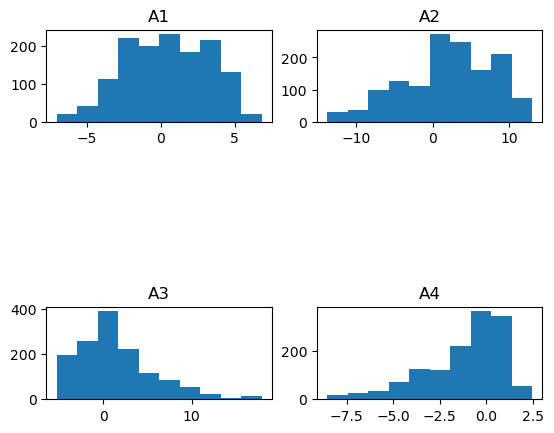

In [39]:
#To see how the the attributes are distributed
fig,axes = plt.subplots(2,2)
axes[0,0].set_title("A1")
axes[0,0].hist(df['A1'])
axes[0,1].set_title("A2")
axes[0,1].hist(df['A2'])
axes[1,0].set_title("A3")
axes[1,0].hist(df['A3'])
axes[1,1].set_title("A4")
axes[1,1].hist(df['A4'])
plt.subplots_adjust(hspace=2)


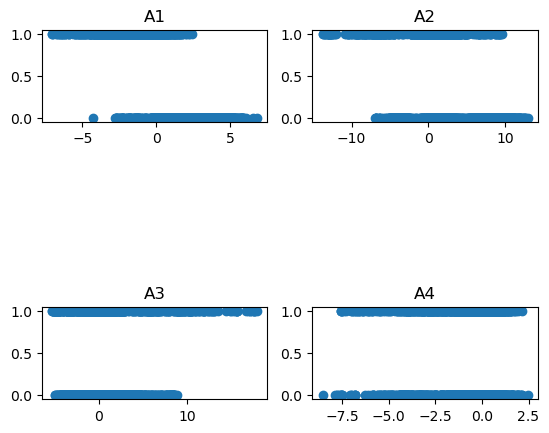

In [40]:
#To see how attributes affect the labels
fig,axes = plt.subplots(2,2)
axes[0,0].set_title("A1")
axes[0,0].scatter(df['A1'],df['Class'])
axes[0,1].set_title("A2")
axes[0,1].scatter(df['A2'],df['Class'])
axes[1,0].set_title("A3")
axes[1,0].scatter(df['A3'],df['Class'])
axes[1,1].set_title("A4")
axes[1,1].scatter(df['A4'],df['Class'])
plt.subplots_adjust(hspace=2)

### Splitting the Data

It is a good practice to split the data into training and test sets. This is to ensure that the model is not overfitting to the training data. The test set is used to evaluate the performance of the model on unseen data. The test set is not used to train the model in any way. The test set is only used to evaluate the performance of the model. You may use the `train_test_split` function from `sklearn.model_selection` to split the data into training and test sets.

It is a good idea to move your data to NumPy arrays now as it will make computing easier.

In [41]:
# your code here
TrainX, TestX, TrainY,  TestY =  train_test_split(Attr,Lab,test_size=0.1)
print(TrainX.shape,TrainY.shape,TestX.shape,TestY.shape)


(1234, 4) (1234,) (138, 4) (138,)


### Denouement

Use this place to report all comparisons and wrap up the calls to the functions written above.

In [42]:
DecisionTree =Node()
DecisionTree = BuildDecisionTree(DecisionTree,TrainX,TrainY,3,Entropy)
PredTestLab=[]
TestLoss=[]
PrintDet(DecisionTree)
for i,x in enumerate(TestX):
    lab, l =Predict(x,DecisionTree)
    PredTestLab.append( lab)
    TestLoss.append(l)
PredTrainLab=[]
TrainLoss=[]
for i,x in enumerate(TrainX):
    lab, l= Predict(x,DecisionTree)
    PredTrainLab.append( lab)
    TrainLoss.append(l)
print(f'Train Accuracy={accuracy_score( TrainY,PredTrainLab)};Test Accuracy= {accuracy_score(TestY,PredTestLab)}')


At node 0 Data is classified by attribute A1 with threshold value of 0.75896
At node 1 Data is classified by attribute A2 with threshold value of 5.1401
At node 3 Data is classified by attribute A1 with threshold value of 0.31803
Impurity of leaf-node 7 is 0.2946152056528072, with label 1
Impurity of leaf-node 8 is 0.9997927658541268, with label 1
At node 4 Data is classified by attribute A1 with threshold value of -3.9934
Impurity of leaf-node 9 is 0.17925606692832127, with label 1
Impurity of leaf-node 10 is 0.07823246525771237, with label 0
At node 2 Data is classified by attribute A3 with threshold value of -1.8785
At node 5 Data is classified by attribute A2 with threshold value of 4.8731
Impurity of leaf-node 11 is 0.27619542764793925, with label 1
Impurity of leaf-node 12 is 0, with label 0
Impurity of leaf-node 6 is 0, with label 0
Train Accuracy=0.953808752025932;Test Accuracy= 0.9637681159420289


Accuracy: 0.9637681159420289


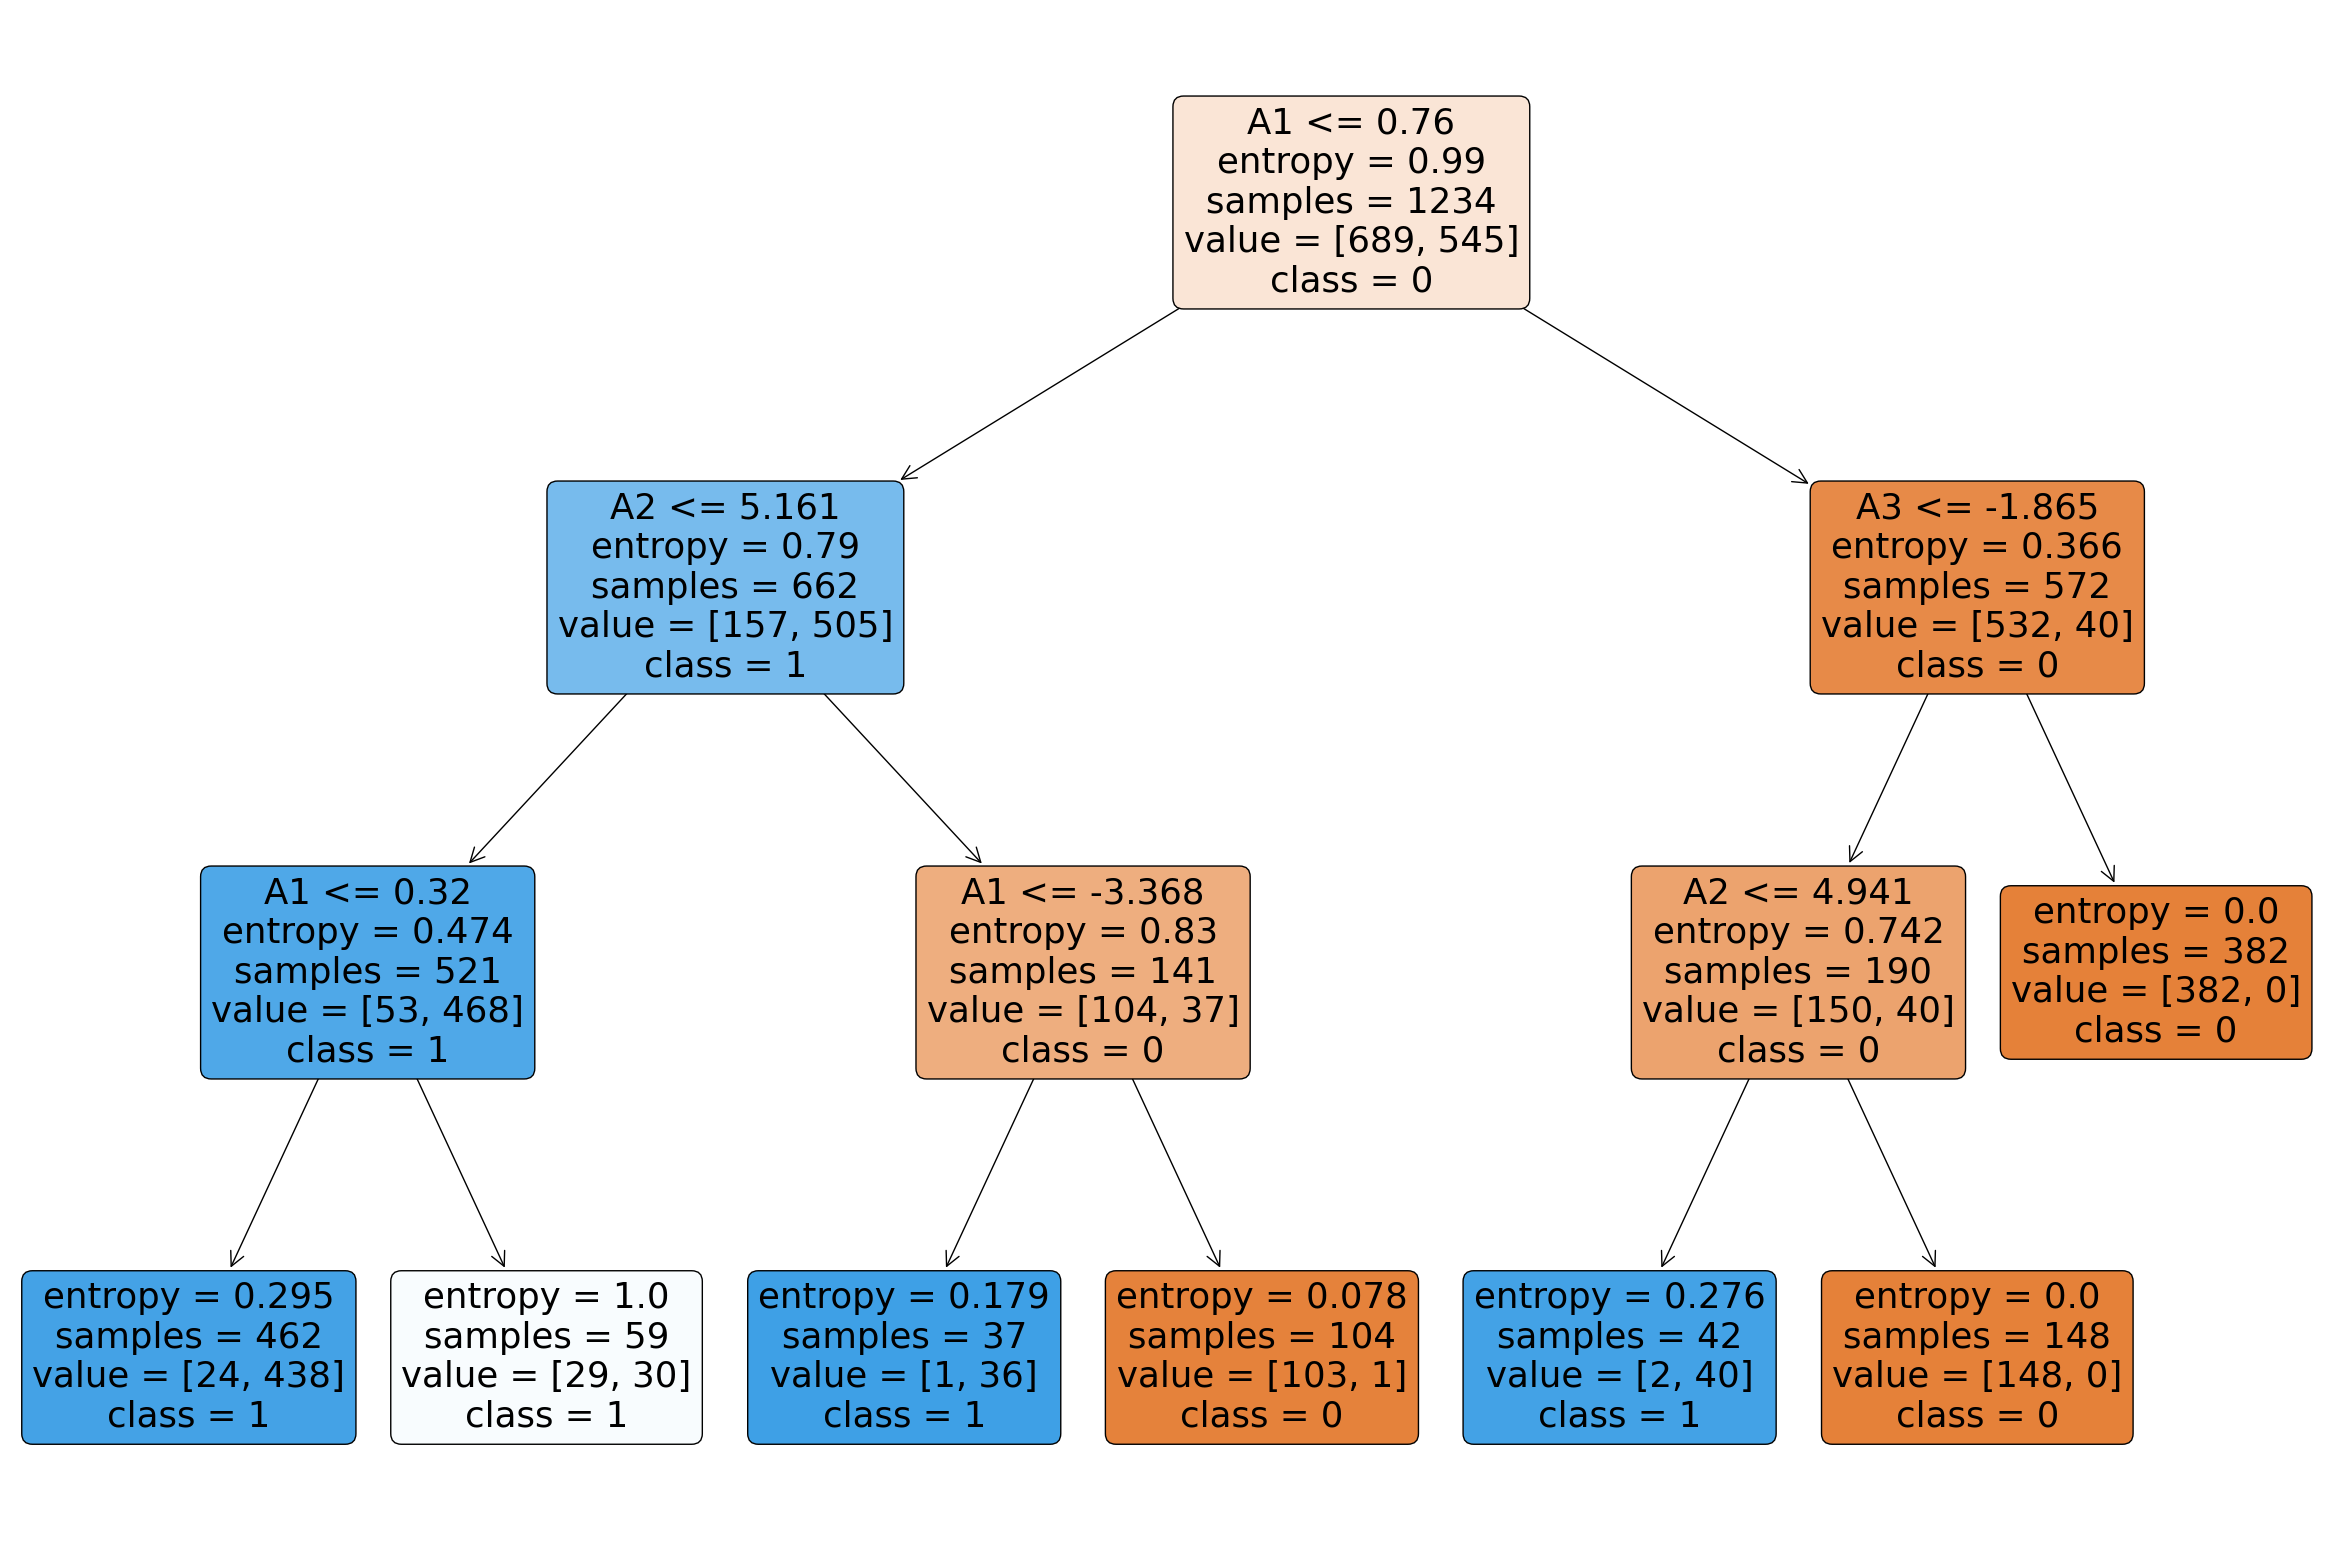

In [43]:
skDecisionTree(TrainX, TestX, TrainY,  TestY,'entropy')

Accuracy: 0.9202898550724637


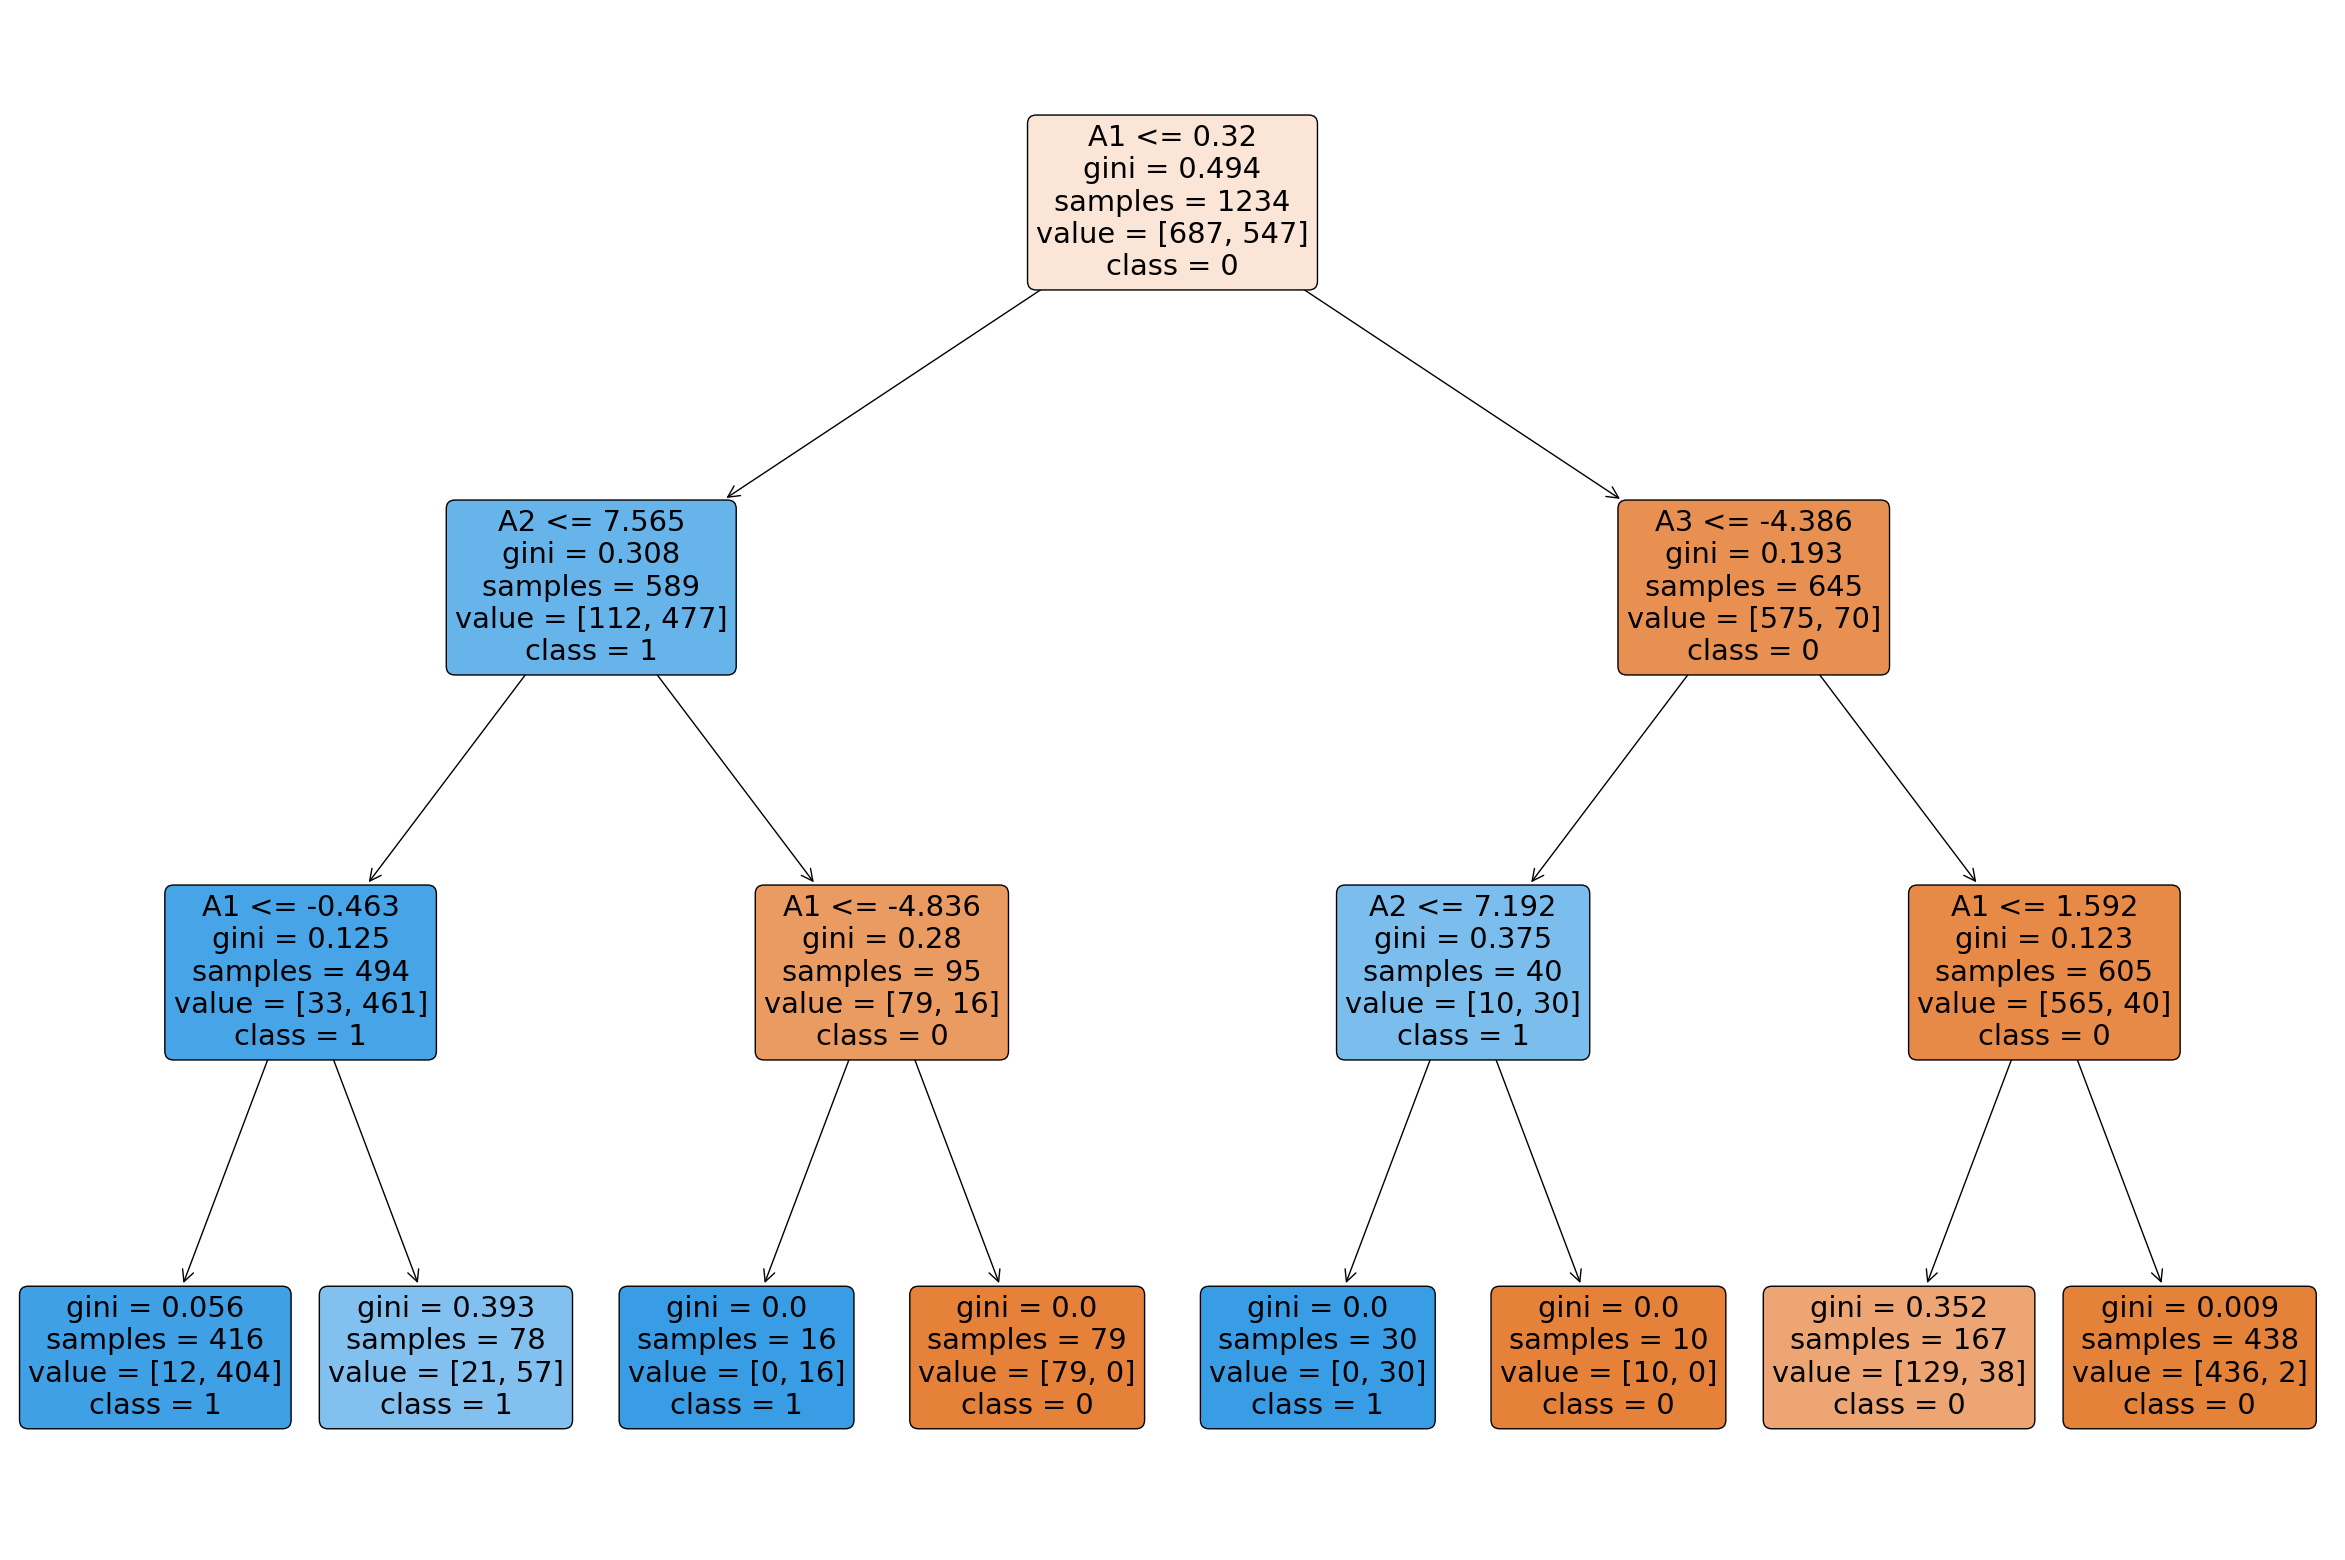

In [11]:
skDecisionTree(TrainX, TestX, TrainY,  TestY,'gini')